In [1]:
import re

import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
from extra_geom import AGIPD_1MGeometry

In [3]:
import crystfel_stream as cstr

In [4]:
agipd_geom_file = "../../geom/agipd_p700000_r0030_v01.geom"
agipd_geom = AGIPD_1MGeometry.from_crystfel_geom(agipd_geom_file)
print(agipd_geom.expected_data_shape)

(16, 512, 128)


In [5]:
stream_file = "../../xwiz/t_03/p700000_r0030.stream"
with open(stream_file, 'r') as st_in:
    stream_data = cstr.read_crystfel_stream(st_in)

In [6]:
all_matching_peaks = []
for fr_key in stream_data:
    if stream_data[fr_key]['crystal'] is None:
        continue
    all_matching_peaks += stream_data[fr_key]['peaks']

In [7]:
sum_peaks_intensity = np.zeros(agipd_geom.expected_data_shape)
sum_peaks_num = np.zeros(agipd_geom.expected_data_shape)

panel_re = r'p(\d+)a\d'
for peak in all_matching_peaks:
    panel_match = re.match(panel_re, peak['panel'])
    if panel_match is None:
        print(f"Could not identify panel id from {peak['panel']}.")
        continue
    val_panel = int(panel_match.group(1))
    val_ss = int(peak['ss'])
    val_fs = int(peak['fs'])
    val_intensity = peak['intensity']

    sum_peaks_intensity[val_panel, val_ss, val_fs] += val_intensity
    sum_peaks_num[val_panel, val_ss, val_fs] += 1

In [8]:
sum_peaks_num_to_div = sum_peaks_num.copy()
sum_peaks_num_to_div[sum_peaks_num == 0] = 1

In [9]:
sum_peaks_avg_intensity = sum_peaks_intensity / sum_peaks_num_to_div

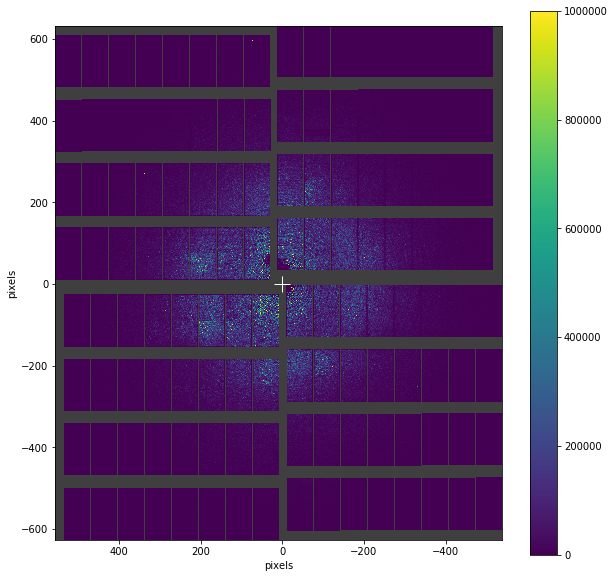

In [10]:
agipd_geom.plot_data_fast(sum_peaks_intensity, vmin=0, vmax=1000000)

In [11]:
#agipd_geom.plot_data_fast(sum_peaks_avg_intensity, vmin=0, vmax=70000)

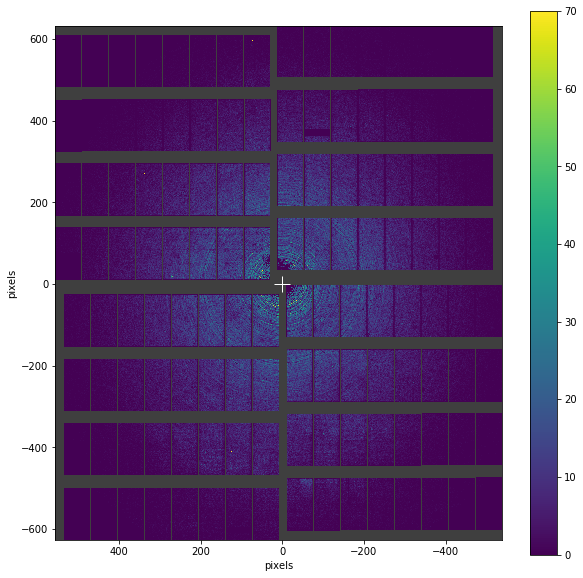

In [12]:
agipd_geom.plot_data_fast(sum_peaks_num, vmin=0, vmax=70)

In [13]:
out_sum_peaks_file = "sum_peaks_p700000_r0030.h5"
with h5py.File(out_sum_peaks_file, 'w') as fout:
    fout.create_dataset('/sum_peaks/intensity_sum', data=sum_peaks_intensity, dtype='float32')
    fout.create_dataset('/sum_peaks/peaks_num', data=sum_peaks_num, dtype='float32')
    fout.create_dataset('/sum_peaks/avg_intensity', data=sum_peaks_num, dtype='float32')